# HR (RMSSD)

## Calculate RMSSD for each trial

In [26]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

def rmssd_from_rr(rr_ms: pd.Series) -> float:
    rr = rr_ms.dropna().values.astype(float)
    if len(rr) < 2:
        return np.nan
    diff = np.diff(rr)
    return np.sqrt(np.mean(diff**2))

# load merged experiment JSON
with open("experiment_data_with_hr.json", "r", encoding="utf-8") as f:
    participants = json.load(f)

rows = []
for p in participants:
    pid = p["participant_id"]

    for stim in p["stimuli"]:
        vid_id = stim["video_id"]
        stim_id = stim["id"]

        hr_rows = stim.get("heart_rate", [])
        if not hr_rows:
            rmssd_ms = np.nan
        else:
            df_hr = pd.DataFrame(hr_rows)

            if "ArtifactCorrectedRR" not in df_hr.columns or "ts" not in df_hr.columns:
                rmssd_ms = np.nan
            else:
                df_hr["ts"] = pd.to_datetime(df_hr["ts"], errors="coerce")
                df_hr = df_hr.dropna(subset=["ts", "ArtifactCorrectedRR"]).sort_values("ts")

                rmssd_ms = rmssd_from_rr(df_hr["ArtifactCorrectedRR"])

        # participant's belief from JSON
        belief = stim.get("video_response", {}).get("belief")

        rows.append({
            "participant_id": pid,
            "stim_id": stim_id,
            "video_id": vid_id,
            "belief": belief.strip(),
            "RMSSD_ms": rmssd_ms,
            "RMSSD_seconds": rmssd_ms / 1000.0 if pd.notna(rmssd_ms) else np.nan,
        })

rmssd_df = pd.DataFrame(rows)
rmssd_df.to_csv("rmssd_per_video.csv", index=False)

rmssd_df


,participant_id,stim_id,video_id,belief,RMSSD_ms,RMSSD_seconds
0,1,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,6.574545,0.006575
1,1,2,5768645-uhd_3840_2160_25fps.mp4,Human Generated,3.438652,0.003439
2,1,3,18840567-hd_1920_1080_30fps.mp4,AI Generated,9.947126,0.009947
3,1,4,11946387_3840_2160_30fps.mp4,AI Generated,11.292927,0.011293
4,2,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,9.658932,0.009659
...,...,...,...,...,...,...
83,22,4,5768645-uhd_3840_2160_25fps.mp4,AI Generated,56.831514,0.056832
84,23,1,18840567-hd_1920_1080_30fps.mp4,Human Generated,22.854238,0.022854
85,23,2,11946387_3840_2160_30fps.mp4,Human Generated,20.940313,0.020940
86,23,3,5768645-uhd_3840_2160_25fps.mp4,AI Generated,18.141420,0.018141


## Calculate RMSSD within subjects (average per belief) 

In [27]:
# Compute participant-level means
mean_table = (
    rmssd_df
    .pivot_table(
        index="participant_id",
        columns="belief",
        values="RMSSD_ms",
        aggfunc="mean"
    )
)

# Compute within-subject difference
mean_table["diff"] = (
    mean_table["AI Generated"] - mean_table["Human Generated"]
)

mean_table.to_csv("rmssd_per_participant.csv")

mean_table.head()

belief,AI Generated,Human Generated,diff
participant_id,,,
1,10.620026,5.006598,5.613428
2,3.578088,9.311638,-5.733550
3,6.638202,8.779479,-2.141277
4,8.045195,8.636253,-0.591058
5,34.008383,32.273139,1.735244


## Check for normal distribution

### Shapiro–Wilk Normality Test

In [29]:
from scipy.stats import shapiro

stat, p = shapiro(mean_table['diff'])

print(f"Shapiro-Wilk Test statistic: {stat:.4f}")
print(f"p-value: {p:.4f}")

if p > 0.05:
    print("✔ Differences appear normally distributed (fail to reject H0)")
else:
    print("✖ Differences are NOT normally distributed (reject H0)")


Shapiro-Wilk Test statistic: 0.8167
p-value: 0.0009
✖ Differences are NOT normally distributed (reject H0)


### KDE + QQ Plot

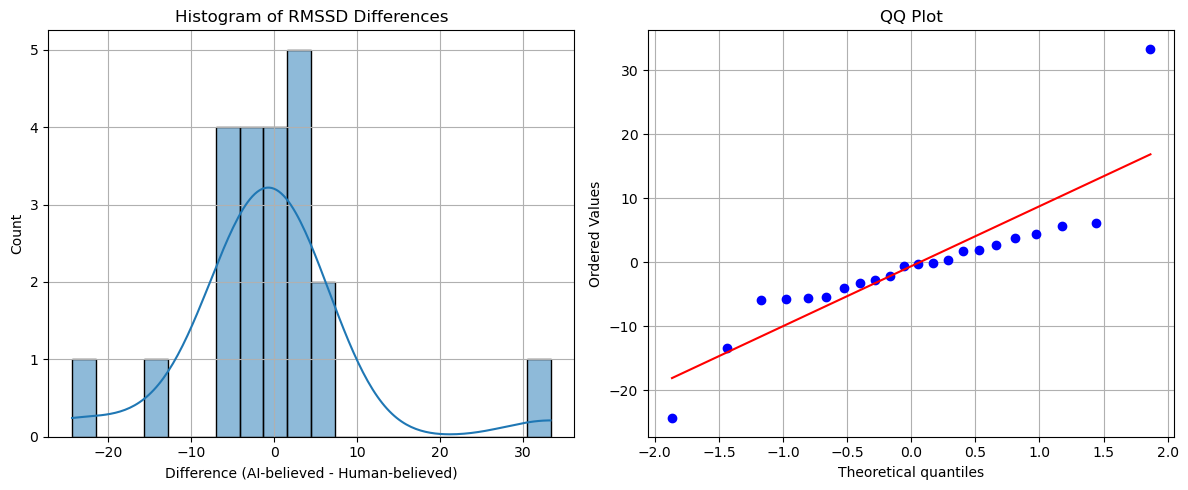

n = 22
Wilcoxon W = 102.000, p = 0.4434
approx. z = -0.795, effect size r = -0.170
median AI = 32.323, median Human = 32.109, median(AI - Human) = -0.463


In [30]:
from scipy.stats import wilcoxon
import seaborn as sns
import scipy.stats as stats

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram + KDE
sns.histplot(mean_table['diff'], kde=True, ax=ax[0], bins=20)
ax[0].set_title("Histogram of RMSSD Differences")
ax[0].set_xlabel("Difference (AI-believed - Human-believed)")
ax[0].grid(True)

# QQ Plot
stats.probplot(mean_table['diff'], dist="norm", plot=ax[1])
ax[1].set_title("QQ Plot")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# --- Add Wilcoxon signed-rank test on participant-level means ---

# use pivot result
# mean_table is created earlier in this notebook
paired = mean_table[["AI Generated", "Human Generated"]].dropna()
ai_vals = paired["AI Generated"].values
human_vals = paired["Human Generated"].values

# Wilcoxon signed-rank (two-sided)
stat, p = wilcoxon(ai_vals, human_vals, alternative="two-sided", zero_method="wilcox")
n = len(ai_vals)

# approximate effect size r from z
expected_W = n * (n + 1) / 4.0
std_W = np.sqrt(n * (n + 1) * (2 * n + 1) / 24.0)
z = (stat - expected_W) / std_W if std_W > 0 else np.nan
r = z / np.sqrt(n) if n > 0 else np.nan

print(f"n = {n}")
print(f"Wilcoxon W = {stat:.3f}, p = {p:.4f}")
print(f"approx. z = {z:.3f}, effect size r = {r:.3f}")

# also print medians and median difference for context
median_ai = np.median(ai_vals)
median_human = np.median(human_vals)
median_diff = np.median(ai_vals - human_vals)
print(f"median AI = {median_ai:.3f}, median Human = {median_human:.3f}, median(AI - Human) = {median_diff:.3f}")

# Interpretation hint:
# If p < 0.05, reject null of no median difference (two-sided).

# SAM

## Calculate SAM for each trial

In [31]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

with open("experiment_data_with_hr.json", "r", encoding="utf-8") as f:
    participants = json.load(f)

SAMS = ['SAM_1', 'SAM_2', 'SAM_3']

rows = []
for p in participants:
    pid = p["participant_id"]

    for stim in p["stimuli"]:
        vid_id = stim["video_id"]
        stim_id = stim["id"]

        sam_rows = stim["video_response"]
        sam = sam_rows["sam"]
        belief = sam_rows["belief"].strip()

        rows.append({
            "participant_id": pid,
            "stim_id": stim_id,
            "video_id": vid_id,
            "belief": belief,
            "SAM_1": sam[0],
            "SAM_2": sam[1],
            "SAM_3": sam[2],
        })

sam_df = pd.DataFrame(rows)
sam_df.set_index("participant_id", inplace=True)
sam_df.to_csv("sam_per_video.csv")

sam_df


,stim_id,video_id,belief,SAM_1,SAM_2,SAM_3
participant_id,,,,,,
1,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,5.0,2.0,3.0
1,2,5768645-uhd_3840_2160_25fps.mp4,Human Generated,3.0,2.0,1.0
1,3,18840567-hd_1920_1080_30fps.mp4,AI Generated,5.0,1.0,1.0
1,4,11946387_3840_2160_30fps.mp4,AI Generated,4.0,1.0,1.0
2,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,4.0,2.0,2.0
...,...,...,...,...,...,...
22,4,5768645-uhd_3840_2160_25fps.mp4,AI Generated,3.0,3.0,3.0
23,1,18840567-hd_1920_1080_30fps.mp4,Human Generated,5.0,2.0,3.0
23,2,11946387_3840_2160_30fps.mp4,Human Generated,5.0,5.0,3.0


## Calculate SAM within subjects (average per belief) 

In [32]:
# avg per participant-belief for each SAM dimension
mean_table = (sam_df 
    .groupby(['participant_id', 'belief'])
    [SAMS]
    .mean()
    .unstack('belief')
)

mean_table.to_csv("sam_per_participant.csv")

mean_table

SAM_1                        SAM_2                  \
belief         AI Generated Human Generated AI Generated Human Generated   
participant_id                                                             
1                       4.5             4.0          1.0             2.0   
2                       4.0             3.5          3.0             2.5   
3                       3.0             3.5          1.5             2.5   
4                       3.5             4.0          3.5             3.0   
5                       2.5             4.0          3.0             3.0   
6                       3.5             4.0          3.5             1.5   
7                       4.0             3.5          1.0             1.5   
8                       4.5             3.5          2.0             3.0   
10                      2.5             5.0          3.0             1.5   
11                      3.0             4.5          3.0             2.0   
12                      3.5             4.0          2.0             1.0   
13                      3.0             3.0          1.0             1.0   
14                      3.5             5.0          3.5             2.5   
15                      3.5             3.5          3.5             2.5   
16                      3.5             4.5          3.0             2.5   
17                      3.5             3.0          2.5             3.0   
18                      3.0             4.5          3.5             1.5   
19                      3.5             3.5          2.5             2.0   
20                      4.0             4.5          3.5             3.0   
21                      3.0             4.5          3.5             2.5   
22                      3.0             3.5          3.0             2.0   
23                      4.0             5.0          2.5             3.5   

                      SAM_3                  
belief         AI Generated Human Generated  
participant_id                               
1                       1.0             2.0  
2                       2.0             2.0  
3                       2.0             1.5  
4                       4.0             4.0  
5                       3.5             3.0  
6                       1.5             2.5  
7                       2.0             1.0  
8                       2.0             3.5  
10                      3.0             4.0  
11                      3.0             2.5  
12                      4.0             4.5  
13                      3.0             3.5  
14                      3.0             2.0  
15                      2.0             2.5  
16                      5.0             5.0  
17                      3.0             2.5  
18                      2.5             2.0  
19                      2.5             2.5  
20                      3.0             3.0  
21                      3.5             3.5  
22                      3.5             2.5  
23                      2.5             3.0

# Focus on the stimuli

## Calculate focus for each trial

In [33]:
import pandas as pd
import json

with open("experiment_data_with_hr.json", "r", encoding="utf-8") as f:
    participants = json.load(f)

rows = []
for p in participants:
    pid = p["participant_id"]

    for i, stim in enumerate(p["stimuli"]):
        vid_id = stim["video_id"]
        stim_id = stim["id"]
        belief = stim["video_response"]["belief"].strip()
        focus = p["focus"]["all_ratings"][i]

        rows.append({
            "participant_id": pid,
            "stim_id": stim_id,
            "video_id": vid_id,
            "belief": belief,
            "focus": focus,
        })

focus_df = pd.DataFrame(rows)
focus_df.set_index("participant_id", inplace=True)
focus_df.to_csv("focus_per_video.csv")

focus_df


,stim_id,video_id,belief,focus
participant_id,,,,
1,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,2.0
1,2,5768645-uhd_3840_2160_25fps.mp4,Human Generated,4.0
1,3,18840567-hd_1920_1080_30fps.mp4,AI Generated,5.0
1,4,11946387_3840_2160_30fps.mp4,AI Generated,4.0
2,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,4.0
...,...,...,...,...
22,4,5768645-uhd_3840_2160_25fps.mp4,AI Generated,2.0
23,1,18840567-hd_1920_1080_30fps.mp4,Human Generated,5.0
23,2,11946387_3840_2160_30fps.mp4,Human Generated,5.0


## Calculate focus within subjects (average per belief) 

In [34]:
# avg per participant-belief for focus
mean_table = focus_df.groupby(['participant_id', 'belief'])['focus'].mean().unstack()

mean_table.to_csv("focus_per_participant.csv")

mean_table

belief,AI Generated,Human Generated
participant_id,,
1,4.5,3.0
2,5.0,4.0
3,2.0,3.0
4,4.0,2.5
5,5.0,2.5
6,4.5,4.0
7,5.0,3.0
8,4.5,4.0
10,5.0,4.5


# Attitude towards AI

## Calculate attitude for each trial

In [35]:
import pandas as pd
import json

with open("experiment_data_with_hr.json", "r", encoding="utf-8") as f:
    participants = json.load(f)

rows = []
for p in participants:
    pid = p["participant_id"]
    attitude = p["opinion"]
    rows.append({
        "participant_id": pid,
        "attitude": attitude,
    })

attitude_df = pd.DataFrame(rows)
attitude_df.set_index("participant_id", inplace=True)
attitude_df.to_csv("attitude_per_participant.csv")

attitude_df


,attitude
participant_id,
1,2.0
2,4.0
3,3.0
4,2.0
5,1.0
6,3.0
7,1.0
8,2.0
10,4.0
